# Análise de Eficiência de Fretes
Este projeto tem como objetivo analisar dados de distribuição de livros didáticos a partir do **Centro de Distribuição (CD)**, identificando **fretes ineficientes** e propondo **recomendações para otimizar**.

Iremos dividir este projeto em três partes:

- 1. Entendimento e Preparação dos Dados
- 2. Definição de Métricas e Análise Exploratória
- 3. Modelagem e Recomendações

 ## 1: Entendimento e Preparação dos Dados

Vamos inciar com a inspeção dos dados com objetivo de identificar os formatos, datas, valores nulos, duplicidades e outras inconsistências.

Temos duas bases de dados, são elas:

- `base_informações.csv` que contem as seguintes colunas:

    - **ID_Pedido:** Código único de identificação do pedido;
    - **Data:** Data do pedido;
    - **Modal:** Modal usado para o transporte;
    - **Cidade:** Cidade de destino da entrega;
    - **Valor_pedido:** Valor do pedido.

- `base_pedidos.csv` que contem as seguintes colunas:
    - **ID_Pedido:** Código único de identificação do pedido;
    - **Distância:** Distância entre o CD (Centro de Distribuição) e o cliente (Vamos assumir que a distância está em Km);
    - **Peso_Kg:** Peso em Kilograma do pedido;
    - **Preco_custo:** Preço de custo do pedido, no caso do material dos livros;
    - **Custo_Frete:** Custo do frete.

    Outras informações são: 

    - **Modal de Transporte Dedicado:** consiste na contratação de um veículo exclusivo pelo Centro
    de Distribuição (CD), diretamente com a transportadora, para o transporte de uma carga
    fechada. Esse modal possui uma capacidade máxima de 1.500 kg.
    - **Modal de Transporte Fracionado:** ocorre quando o Centro de Distribuição (CD) encaminha o
    pedido do cliente por meio de uma transportadora. A transportadora realiza a coleta da
    mercadoria e a entrega ao cliente utilizando sua logística já estruturada, consolidando a
    carga com os pedidos de outros clientes atendidos pela transportadora.
    - Por padrão, todos os pedidos têm origem com o modal de entrega Fracionado. 
    O representante comercial da Somos Educação pode realizar uma solicitação ao CD para
    transformar o modal em Dedicado.
    - Toda alteração de modal Fracionado para Dedicado deve ser aprovado pelo time competente no CD.

In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np

# Visualização 
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML # type: ignore
import plotly.graph_objects as go # type: ignore

# Algumas configurações
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configuração para o notebook e plotagem de imagens
%matplotlib inline
def jupyter_settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container { width:100% !important; }</style>'))
    sns.set()

jupyter_settings()


### 1.1: Importando o conjunto de dados

In [2]:
# Importando as duas bases de dados
df_info = pd.read_csv('../data/base_informações.csv', sep=';')
df_pedidos = pd.read_csv('../data/base_pedidos.csv', sep=';')

In [3]:
# visualizando a primeira base
df_info.head()

,ID_Pedido,Distancia,Peso_Kg,Preco_custo,Custo_Frete
0,F1,812,881,22025,5000
1,F2,868,882,22050,5000
2,F3,864,938,23450,5000
3,F4,828,970,24250,5000
4,F5,797,853,21325,5000


In [4]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   ID_Pedido    1048575 non-null  object
 1   Distancia    1048575 non-null  int64 
 2   Peso_Kg      1048575 non-null  int64 
 3   Preco_custo  1048575 non-null  int64 
 4   Custo_Frete  1048575 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 40.0+ MB


Para a base de dados `df_info`temos ao todo 1048575 entradas e a princípio todas as colunas não possuem nenhuma entrada nula. Também temos o fato que a coluna `ID_Pedido` é do formato objeto. As demais colunas são do tipo inteiro, condizentes com suas tipologias.

In [5]:
# Visualizando a segunda base
df_pedidos.head()

,ID_Pedido,Data,Modal,Cidade,Valor_pedido
0,F1,19APR2020,Dedicado,Florianopolis,52860
1,F2,16AUG2024,Dedicado,Florianopolis,52920
2,F3,10/nov/24,Dedicado,Florianopolis,56280
3,F4,07AUG2022,Dedicado,Florianopolis,58200
4,F5,14SEP2020,Dedicado,Florianopolis,51180


In [6]:
df_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   ID_Pedido     1048575 non-null  object
 1   Data          1048575 non-null  object
 2   Modal         1048575 non-null  object
 3   Cidade        1048575 non-null  object
 4   Valor_pedido  1048575 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 40.0+ MB


Aqui temos novamente as 1048575 entradas, a mesma quantidade da base anterior, o que sugere que poderemos juntar as duas bases. 
Um ponto importante é a coluna `Data` que além de ter o formato como objeto, também possuem entradas não padronizadas.

In [7]:
# Tratando as datas para terem a mesma formatação
df_pedidos['Data'] = pd.to_datetime(df_pedidos['Data'], errors='coerce', dayfirst=True)
# Ordenando para o formato para o brasileiro
df_pedidos['Data'].dt.strftime('%d/%m/%Y');

/tmp/ipykernel_51125/980590163.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pedidos['Data'] = pd.to_datetime(df_pedidos['Data'], errors='coerce', dayfirst=True)


In [8]:
# Visualizando novamente a segunda base
df_pedidos.head()

,ID_Pedido,Data,Modal,Cidade,Valor_pedido
0,F1,2020-04-19,Dedicado,Florianopolis,52860
1,F2,2024-08-16,Dedicado,Florianopolis,52920
2,F3,2024-11-10,Dedicado,Florianopolis,56280
3,F4,2022-08-07,Dedicado,Florianopolis,58200
4,F5,2020-09-14,Dedicado,Florianopolis,51180


In [9]:
# Visualizando novamente o formato dos dados
df_info.info()
df_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   ID_Pedido    1048575 non-null  object
 1   Distancia    1048575 non-null  int64 
 2   Peso_Kg      1048575 non-null  int64 
 3   Preco_custo  1048575 non-null  int64 
 4   Custo_Frete  1048575 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 40.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   ID_Pedido     1048575 non-null  object        
 1   Data          1048575 non-null  datetime64[ns]
 2   Modal         1048575 non-null  object        
 3   Cidade        1048575 non-null  object        
 4   Valor_pedido  1048575 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage:

Vamos verificar se o `ID_Pedido`em cada base é único.

In [10]:
print(f'Os IDs da base Base_informações são únicos? {'SIM' if df_info['ID_Pedido'].is_unique else 'NÃO'}')
print(f'Os IDs da base Base_Pedidos são únicos? {'SIM' if df_info['ID_Pedido'].is_unique else 'NÃO'}')


Os IDs da base Base_informações são únicos? SIM
Os IDs da base Base_Pedidos são únicos? SIM


Temos que os IDs em abas as bases são únicos, agora vamos verificar se eles corresponde entre si.

In [11]:
# Verificando se cada ID de Base_info está em Base_pedidos

df_info['ID_Pedido'].isin(df_pedidos['ID_Pedido']).value_counts()

ID_Pedido
True    1048575
Name: count, dtype: int64

In [12]:
# Verificando se cada ID de Base_pedidos está em Base_info

df_pedidos['ID_Pedido'].isin(df_info['ID_Pedido']).value_counts()

ID_Pedido
True    1048575
Name: count, dtype: int64

Como temos ao todo 1048575 entradas em ambas as bases e ao verificamos se os IDs de uma base está na outra e vice-versa, e de fato, verificamos que temos correspondência 1 para 1. Desta forma podemos juntar as duas bases em uma única base de dados.

In [13]:
df = pd.merge(
  df_pedidos,
  df_info,
  how='inner', # Junta apenas os IDs presentes nas duas bases
  on='ID_Pedido' # Coluna em comum
)

In [14]:
df.head()

,ID_Pedido,Data,Modal,Cidade,Valor_pedido,Distancia,Peso_Kg,Preco_custo,Custo_Frete
0,F1,2020-04-19,Dedicado,Florianopolis,52860,812,881,22025,5000
1,F2,2024-08-16,Dedicado,Florianopolis,52920,868,882,22050,5000
2,F3,2024-11-10,Dedicado,Florianopolis,56280,864,938,23450,5000
3,F4,2022-08-07,Dedicado,Florianopolis,58200,828,970,24250,5000
4,F5,2020-09-14,Dedicado,Florianopolis,51180,797,853,21325,5000


Agora que temos uma base única, solida e com os dados validados, podemos dar continuidade e iniciar a analise exploratória.

## 2: Definição de Métricas e Análise Exploratória

Para podermos avaliar se os fretes são ineficientes ou nao, precisamos criar alguns métricas que possam quantificar o quanto um frente é eficiente ou se a venda do produto é lucrativa.

1. Indicadores de custo e margem: Esses ajudam a entender se o frete está caro ou barato e se está impactando na margem do pedido.

- **Margem bruta:**
$$\text{Margem bruta(\%)} = \frac{\text{Valor-Pedido}-\text{Preco-custo}-\text{Custo-frete}}{\text{Valor-Pedido}} \times 100$$

- **Custo de frete por pedido:**

$$\text{Custo-frete-por-pedido} = \frac{\text{Custo-frete}}{\text{Valor-pedido}}$$

- **Custo de frete por peso:**

$$\text{Custo-frete-por-Kg} = \frac{\text{Custo-frete}}{\text{Peso-KG}}$$

- **Custo de frete por distância:** 

$$\text{Custo-frete-por-km} = \frac{{\text{Custo-frete}}}{\text{Preco-custo}}$$

- **Markup do pedido:**

$$\text{Markup} = \frac{\text{Valor-pedido}}{\text{Preco-custo}}$$


2. Indicadores de produtividade e eficiência: Esses mostram se o transporte está sendo eficiente, principalmente para comparar dedicado vs fracionado.

- **Peso transportado por Km:**

$$ \text{Kg-por-Km} = \frac{\text{Peso-Kg}}{\text{Distancia}}$$

- **Valor transportado por Km:**

$$ \text{Valor-por-Km} = \frac{\text{Valor-pedido}}{\text{Distancia}}$$

- **Frete relativo ao peso e distância:**

$$\text{Custo-frete-por-KgKm} = \frac{\text{Custo-frete}}{\text{Peso-Kg}\times\text{Distancia}}$$

3. Indicadores comparativos e estratégicos: Esses servem para tomada de decisão sobre rotas, preços e tipos de frete.

- **Comparativo de custo entre modais:** Média do custo por km e por kg para dedicado vs fracionado.
- **Ranking de cidades:** Custo médio de entrega por cidade.
- **Índice de frete sobre preço de custo:**
$$ \text{Custo-frete-sobre-preco-custo} = \frac{\text{Custo-frete}}{\text{Preco-custo}}$$


Vamos calcular essas métricas agora. 

In [70]:
# Margem bruta por pedido
df['Margem_bruta'] = 100* (df['Valor_pedido'] - df['Custo_Frete'] - df['Preco_custo'])/df['Valor_pedido']

# Custo do frete por pedido 
df['custo_frete_por_pedido'] = df['Custo_Frete']/df['Valor_pedido']

# Custo do frete por Kg
df['custo_frete_por_kg'] = df['Custo_Frete']/df['Peso_Kg']

# Custo de frete por distância
df['custo_frete_por_km'] = df['Custo_Frete']/df['Distancia']

# Markup 
df['Markup'] = df['Valor_pedido'] / df['Preco_custo']

# Peso transportado por km
df['kg_por_km'] = df['Peso_Kg'] / df['Distancia']

# Valor transportado por km
df['Valor_por_km'] = df['Valor_pedido'] / df['Distancia']

# Frete relativo ao peso e distância
df['Custo_frete_por_KgKm'] = df['Custo_Frete'] / (df['Peso_Kg'] * df['Distancia'])

# Índice de frete sobre preço de custo

df['Custo_frete_sobre_preco_custo'] = df['Custo_Frete']/df['Preco_custo']

### 2.1: Indicadores de custo e margem

Agora que temos algumas métricas, vamos analisar o seus comportamentos.

Vamos iniciar pela **Margem bruta por pedido** com o objetivo de identificar quais pedidos podem ser mais ou menos lucrativos.

In [16]:
df['Margem_bruta'].agg(['min', 'max', 'mean', 'median'])

min      -82.750000
max        0.570833
mean       0.502486
median     0.543124
Name: Margem_bruta, dtype: float64

Podemos notar que:
- O pedido mais lucrativo tem uma margem bruta de 0.57%.
- O pedido menos lucrativo tem uma margem bruta de -82.75%.
- A media das margens brutas dos pedidos e de 0.50%.

Como temos pedidos com margem negativas, já temos uma indicação de pedidos ineficientes. Vamos inicialmente visualizar por meio histograma para verificar a distribuição da Margem bruta dos pedidos.

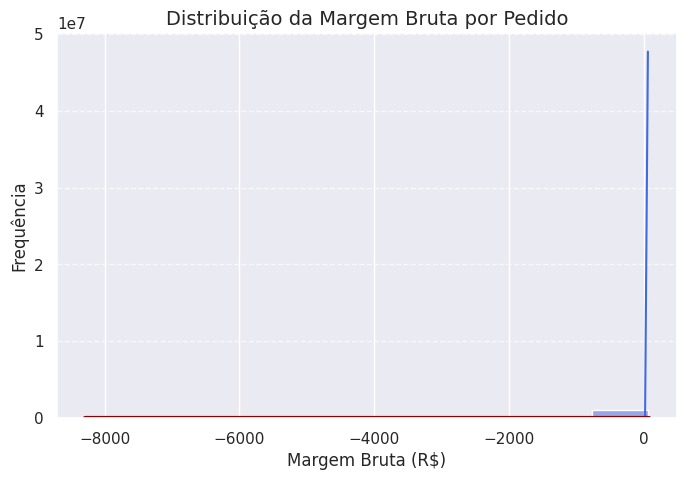

In [71]:
# Histograma
plt.figure(figsize=(8, 5))
sns.histplot(df['Margem_bruta'], bins=10, kde=True, color='royalblue')
sns.kdeplot(df['Margem_bruta'], color='darkred', linewidth=3)
# Personalização
plt.title('Distribuição da Margem Bruta por Pedido', fontsize=14)
plt.xlabel('Margem Bruta (R$)')
plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Podemos notar que temos um pico acima do zero, contudo temos indicativo margem de lucro negativa, o que nos indica que o valor recebido pelo pedido **não cobre** o custo de aquisição do produto/produção e **nem o frete**.

Vamos criar duas categorias para facilitar a comparação. Neste caso, teremos dois grupos iniciais:
- **Grupo 1:** Pedidos lucrativos (Margem_bruta >= 0)
- **Grupo 2:** Pedidos com prejuízo (Margem_bruta < 0)

In [72]:
# Criar coluna de categoria
df['Status_Margem'] = df['Margem_bruta'].apply(lambda x: 'Lucro' if x >= 0 else 'Prejuízo')

In [73]:
print(df['Status_Margem'].value_counts(normalize=True)*100)

Status_Margem
Lucro       99.246597
Prejuízo     0.753403
Name: proportion, dtype: float64


Temos que 99% dos pedidos geram lucros e apenas 0.75%, menos de 1% gera prejuízo.

In [85]:
# Criar função para categorizar
def categorizar_margem(valor):
    if valor >= 0:
        # Faixas positivas: 0-20, 20-40, 40-60, ...
        faixa = (valor // 10) *10
        return f'{int(faixa)} a {int(faixa+10)}'
    else:
        # Faixas negativas: -20 a 0, -40 a -20, -60 a -40, ...
        faixa = (valor // 50) *50
        return f'{int(faixa)} a {int(faixa+50)}'

# Aplicar função
df['Margem_Categoria'] = df['Margem_bruta'].apply(categorizar_margem)

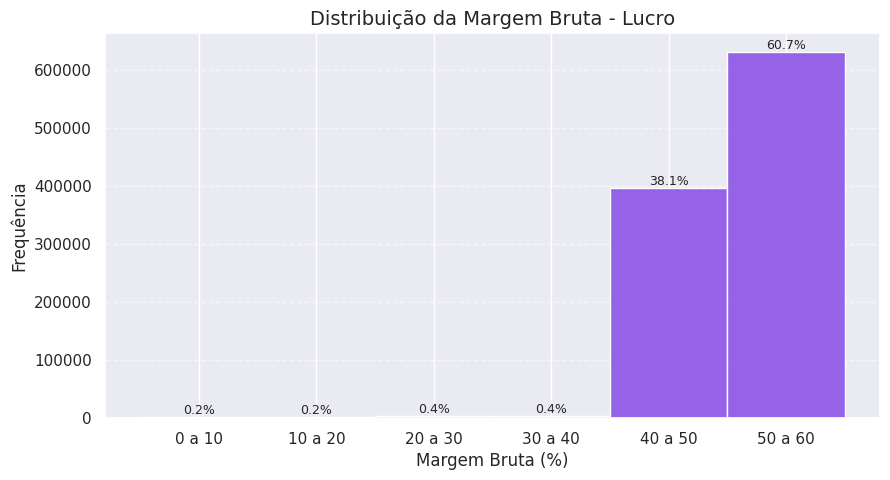

In [87]:
df_lucro = df[df['Status_Margem'] == 'Lucro'].copy()
ordem_categorias = sorted(df_lucro['Margem_Categoria'].unique(), key=lambda x: int(x.split()[0]))

# Converter para categoria ordenada
df_lucro['Margem_Categoria'] = pd.Categorical(
    df_lucro['Margem_Categoria'], 
    categories=ordem_categorias, 
    ordered=True
)


plt.figure(figsize=(10, 5))
ax = sns.histplot(
    data=df_lucro,
    x='Margem_Categoria',
    bins=len(ordem_categorias),
    color='#7934e5'
)

# Calcular total para porcentagem
total = len(df_lucro)

# Adicionar rótulos acima das barras
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        percent = 100 * height / total
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height,
            f'{percent:.1f}%',
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.title('Distribuição da Margem Bruta - Lucro', fontsize=14)
plt.xlabel('Margem Bruta (%)')
plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', alpha=0.6)
# Salvar com fundo transparente
# Fundo da área do gráfico branco

plt.savefig('../imagens/dist_margem_bruta_lucro_hist.png', dpi=300)

plt.show()

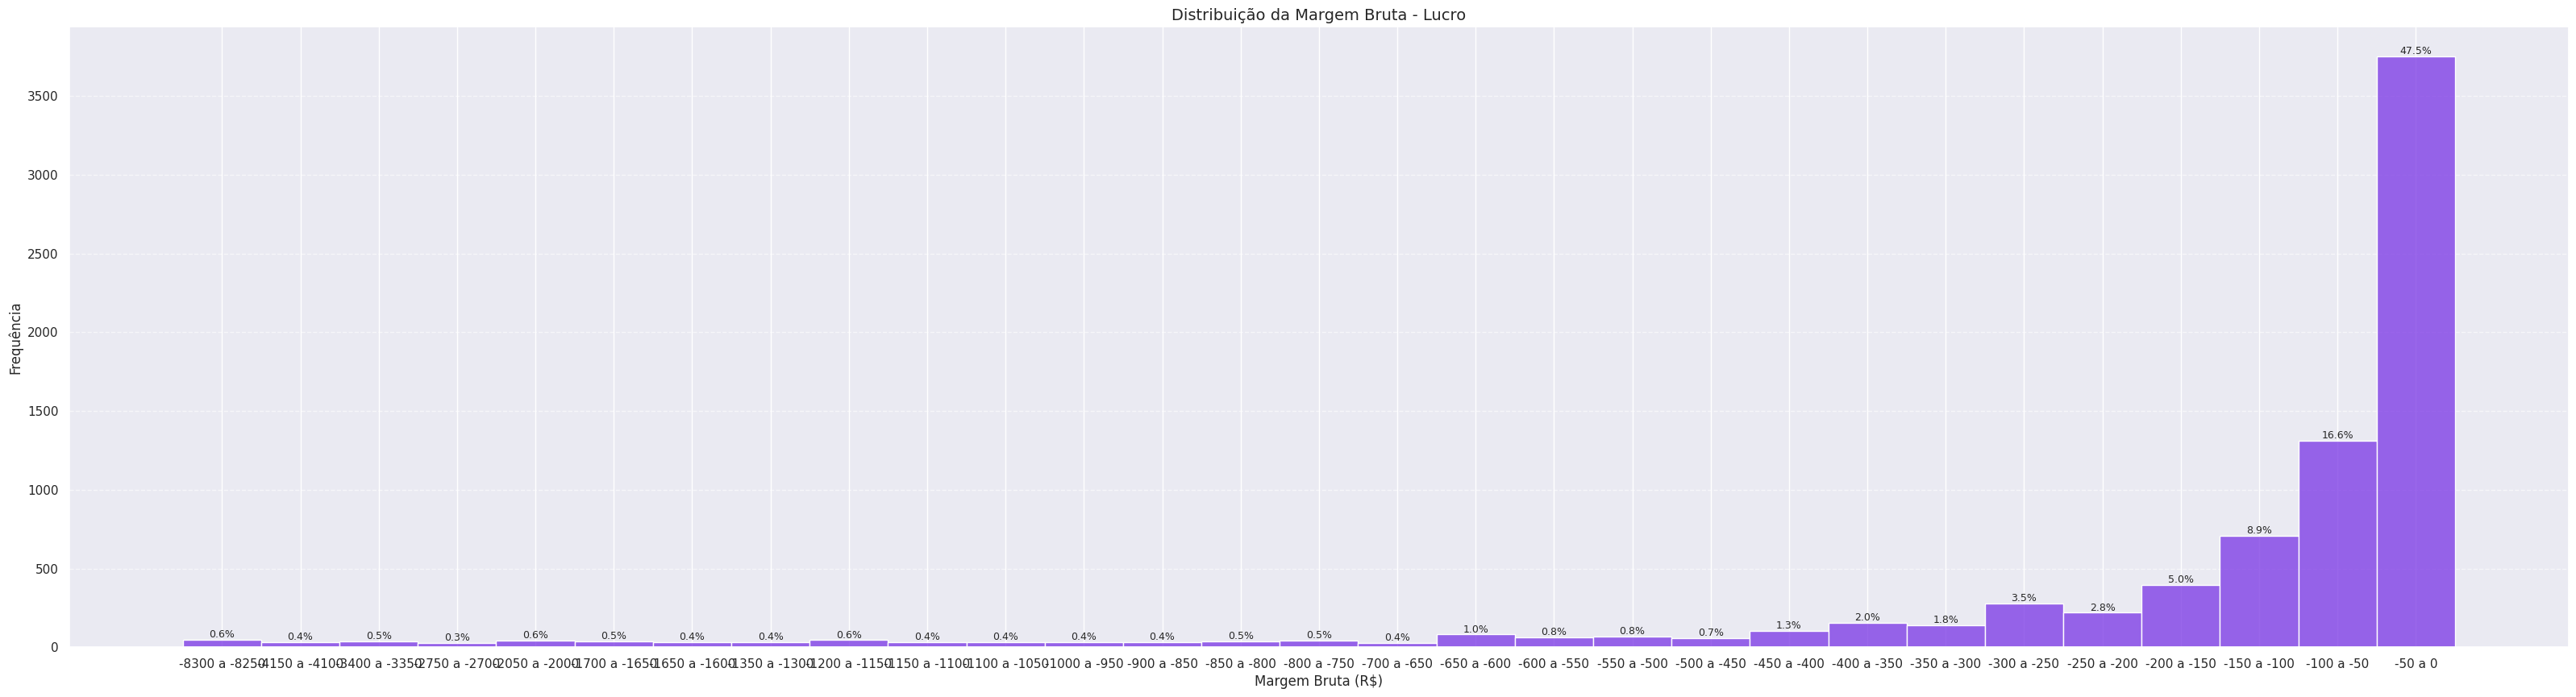

In [88]:
df_prejuizo = df[df['Status_Margem'] == 'Prejuízo'].copy()
ordem_categorias_prej = sorted(df_prejuizo['Margem_Categoria'].unique(), key=lambda x: int(x.split()[0]))

# Converter para categoria ordenada
df_prejuizo['Margem_Categoria'] = pd.Categorical(
    df_prejuizo['Margem_Categoria'], 
    categories=ordem_categorias_prej, 
    ordered=True
)


plt.figure(figsize=(40, 10))
ax = sns.histplot(
    data=df_prejuizo,
    x='Margem_Categoria',
    bins=len(ordem_categorias_prej),
    color='#7934e5'
)

# Calcular total para porcentagem
total = len(df_prejuizo)

# Adicionar rótulos acima das barras
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        percent = 100 * height / total
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height,
            f'{percent:.1f}%',
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.title('Distribuição da Margem Bruta - Lucro', fontsize=14)
plt.xlabel('Margem Bruta (R$)')
plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('../imagens/dist_margem_bruta_prej_hist.png', dpi=300)
plt.show()


Nossa margem lucrativa possuí uma cauda muito longa na esquerda, indo em direção ao zero. Contudo, temos pedidos que gerem Margem Bruta a acima de 40% e abaixo de 60%.

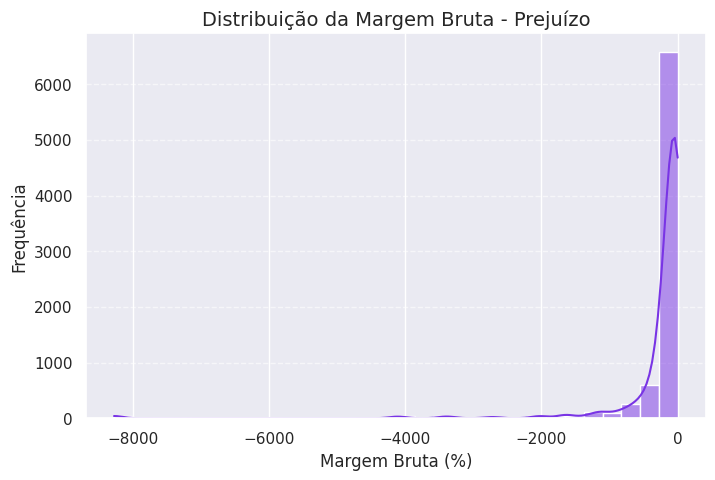

In [89]:
plt.figure(figsize=(8, 5))
sns.histplot(df[df['Status_Margem'] == 'Prejuízo']['Margem_bruta'], kde=True,bins=30, color='#7934e5')
plt.title('Distribuição da Margem Bruta - Prejuízo', fontsize=14)
plt.xlabel('Margem Bruta (%)')
plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('../imagens/dist_margem_bruta_prej_hist2.png', dpi=300)

plt.show()

Quando olhamos para os pedidos que indicam prejuízo, temos uma pico bastante alto logo abaixo de zero e uma calda muito longa na esquerda. 

Podemos calcular o total de prejuízo 

In [90]:
Valor_do_prejuízo = float((df[df['Status_Margem'] == 'Prejuízo']['Margem_bruta'] * df['Valor_pedido']).sum())
Valor_do_prejuízo

-1438987000.0

In [91]:
Valor_do_lucro = float((df[df['Status_Margem'] == 'Lucro']['Margem_bruta'] * df['Valor_pedido']).sum())
Valor_do_lucro

2157373274400.0

Vimos que os pedidos que geram prejuízo representam menos de 1% dos pedidos. Contudo, este valor representa um total de R$ 14,389,870.0. O que nos levar a perguntar por que estes pedidos possuem uma margem bruta negativa. 

In [104]:
df_lucro.describe()

,Data,Valor_pedido,Distancia,Peso_Kg,Preco_custo,Custo_Frete,Margem_bruta,custo_frete_por_pedido,custo_frete_por_kg,custo_frete_por_km,Markup,kg_por_km,Valor_por_km,Custo_frete_por_KgKm,Custo_frete_sobre_preco_custo
count,1040675,1.040675e+06,1.040675e+06,1.040675e+06,1.040675e+06,1.040675e+06,1.040675e+06,1.040675e+06,1.040675e+06,1.040675e+06,1.040675e+06,1.040675e+06,1.040675e+06,1.040675e+06,1.040675e+06
mean,2022-07-15 19:46:43.380113920,3.903723e+04,4.268186e+02,6.506205e+02,1.626551e+04,2.041199e+03,5.253201e+01,5.801324e-02,3.480795e+00,5.352301e+00,2.400000e+00,3.072381e+00,1.843429e+02,9.742166e-03,1.392318e-01
min,2020-01-01 00:00:00,6.000000e+01,9.500000e+01,1.000000e+00,2.500000e+01,2.000000e+00,5.827506e-02,1.250000e-02,7.500000e-01,6.749156e-03,2.400000e+00,1.124859e-03,6.749156e-02,5.624297e-03,3.000000e-02
25%,2021-04-13 00:00:00,2.256000e+04,1.080000e+02,3.760000e+02,9.400000e+03,7.500000e+02,4.848306e+01,2.500000e-02,1.500000e+00,4.015238e+00,2.400000e+00,9.119497e-01,5.471698e+01,6.968865e-03,6.000000e-02
50%,2022-07-26 00:00:00,4.914000e+04,3.340000e+02,8.190000e+02,2.047500e+04,1.764000e+03,5.433565e+01,3.997683e-02,2.398610e+00,6.063158e+00,2.400000e+00,2.141414e+00,1.284848e+02,7.632743e-03,9.594438e-02
75%,2023-10-19 00:00:00,5.460000e+04,7.840000e+02,9.100000e+02,2.275000e+04,2.892000e+03,5.583333e+01,9.850276e-02,5.910165e+00,6.742671e+00,2.400000e+00,4.363636e+00,2.618182e+02,9.014206e-03,2.364066e-01
max,2024-12-31 00:00:00,6.000000e+04,8.890000e+02,1.000000e+03,2.500000e+04,5.000000e+03,5.708333e+01,5.827506e-01,3.496503e+01,1.105263e+01,2.400000e+00,1.052632e+01,6.315789e+02,3.588517e-01,1.398601e+00
std,NaN,1.869062e+04,3.132830e+02,3.115103e+02,7.787758e+03,1.668116e+03,4.838772e+00,4.838772e-02,2.903263e+00,2.201910e+00,4.440894e-16,2.978709e+00,1.787226e+02,9.514052e-03,1.161305e-01


In [92]:
df_prejuizo.describe()

,Data,Valor_pedido,Distancia,Peso_Kg,Preco_custo,Custo_Frete,Margem_bruta,custo_frete_por_pedido,custo_frete_por_kg,custo_frete_por_km,Markup,kg_por_km,Valor_por_km,Custo_frete_por_KgKm,Custo_frete_sobre_preco_custo
count,7900,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7.900000e+03,7900.000000,7900.000000,7900.000000,7900.000000
mean,2023-12-28 22:25:45.721519104,3208.086076,596.269494,53.468101,1336.702532,3692.886076,-250.550996,3.088843,185.330598,6.294690,2.400000e+00,0.091071,5.464277,0.426688,7.413224
min,2023-01-01 00:00:00,60.000000,95.000000,1.000000,25.000000,750.000000,-8275.000000,0.584746,35.084746,5.624297,2.400000e+00,0.001134,0.068027,0.039608,1.403390
25%,2023-06-26 00:00:00,1080.000000,335.000000,18.000000,450.000000,2070.000000,-171.666667,0.766667,46.000000,5.917160,2.400000e+00,0.045813,2.748752,0.073331,1.840000
50%,2023-12-29 00:00:00,2640.000000,756.000000,44.000000,1100.000000,5000.000000,-55.821918,1.141553,68.493151,6.242197,2.400000e+00,0.091064,5.463861,0.141355,2.739726
75%,2024-06-28 06:00:00,5100.000000,823.000000,85.000000,2125.000000,5000.000000,-18.333333,2.300000,138.000000,6.596306,2.400000e+00,0.135549,8.132955,0.360332,5.520000
max,2024-12-31 00:00:00,8520.000000,889.000000,142.000000,3550.000000,5000.000000,-0.141243,83.333333,5000.000000,7.894737,2.400000e+00,0.221053,13.263158,7.894737,200.000000
std,NaN,2458.267151,270.561939,40.971119,1024.277979,1636.140223,778.329113,7.783291,466.997468,0.467349,4.441173e-16,0.052341,3.140478,0.942557,18.679899


Podemos olhar entre as cidades qual é a media da Margem Bruta para as categorias Prejuízo e Lucro.

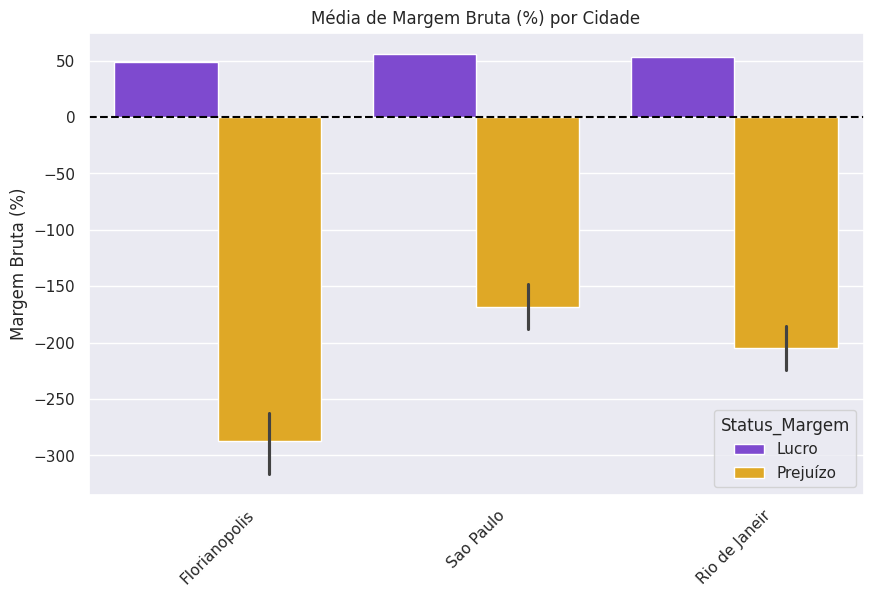

In [93]:
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Cidade', y='Margem_bruta', hue='Status_Margem', palette={'Lucro':'#7934e5','Prejuízo':'#feb507'})
plt.axhline(0, color='black', linestyle='--')
plt.title("Média de Margem Bruta (%) por Cidade")
plt.ylabel("Margem Bruta (%)")
plt.xlabel(None)
plt.xticks(rotation=45)
plt.savefig('../imagens/dist_margem_bruta_media_cidade.png', dpi=300)
plt.show()

Ou ainda mais detalhado, por meio do boxplot.

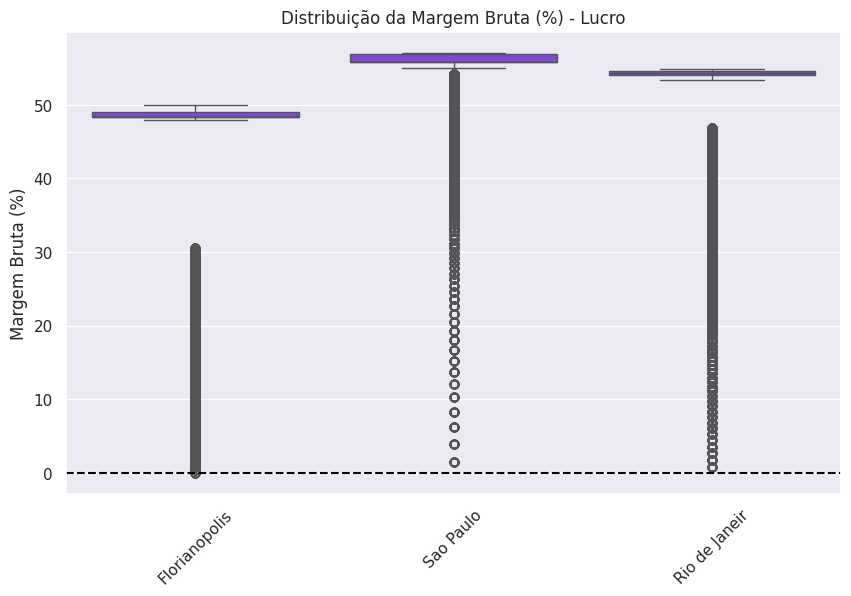

In [107]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df[df['Status_Margem'] == 'Lucro'], 
    x='Cidade', y='Margem_bruta',
    color='#7934e5'
)
plt.axhline(0, color='black', linestyle='--')
plt.title("Distribuição da Margem Bruta (%) - Lucro")
plt.ylabel("Margem Bruta (%)")
plt.xlabel(None)
plt.xticks(rotation=45)
plt.savefig('../imagens/dist_margem_bruta_media_cidade_lucro_boxplot.png', dpi=300)
plt.show()


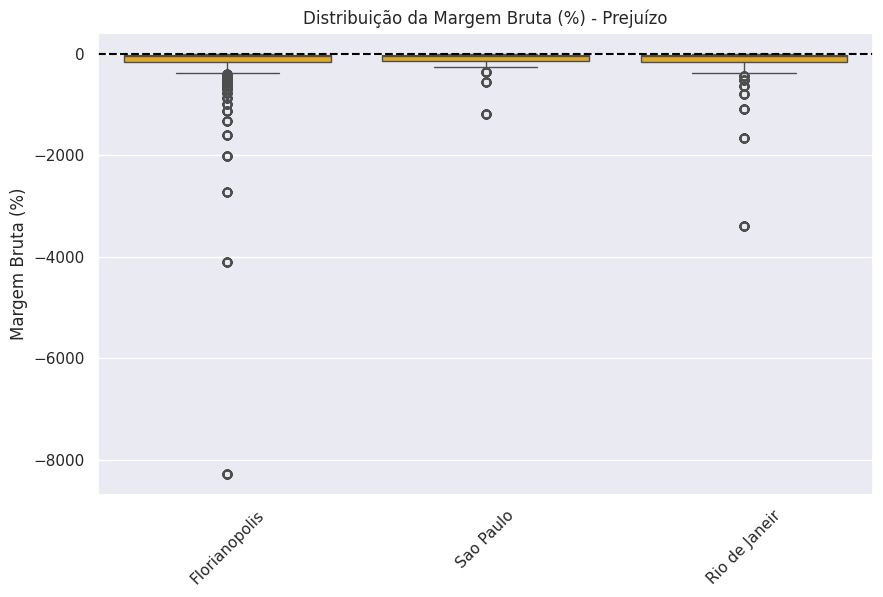

In [106]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df[df['Status_Margem'] == 'Prejuízo'], 
    x='Cidade', y='Margem_bruta',
    color='#feb507'
)
plt.axhline(0, color='black', linestyle='--')
plt.title("Distribuição da Margem Bruta (%) - Prejuízo")
plt.ylabel("Margem Bruta (%)")
plt.xticks(rotation=45)
plt.xlabel(None)
plt.savefig('../imagens/dist_margem_bruta_media_cidade._prej_boxplot.png', dpi=300)

plt.show()

Notamos que temos bastante outliers na Margem Bruta para o Lucro com valores abaixo dos 40% de margem de lucro.

Vamos analisar o comportamento para os tipos de Modal, no caso, Dedicado e Fracionado.

In [108]:
df_prejuizo['Modal'].value_counts(normalize=True)*100

Modal
Dedicado    100.0
Name: proportion, dtype: float64

In [109]:
df_lucro['Modal'].value_counts(normalize=True)*100

Modal
Dedicado      57.745598
Fracionado    42.254402
Name: proportion, dtype: float64

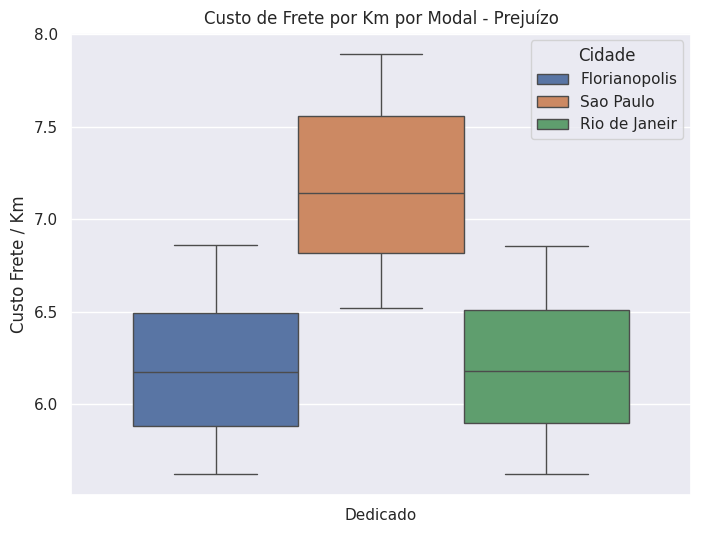

In [113]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df[df['Status_Margem'] == 'Prejuízo'], x='Modal', y='custo_frete_por_km', hue='Cidade')
plt.title("Custo de Frete por Km por Modal - Prejuízo")
plt.ylabel("Custo Frete / Km")
plt.xlabel(None)
plt.savefig('../imagens/custo_frete_por_km_modal_prej.png', dpi=300)

plt.show()

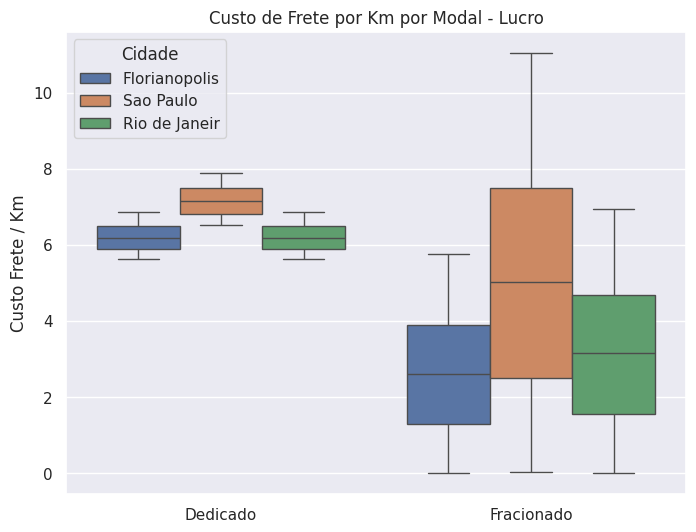

In [112]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df[df['Status_Margem'] == 'Lucro'], x='Modal', y='custo_frete_por_km', hue='Cidade')
plt.title("Custo de Frete por Km por Modal - Lucro")
plt.ylabel("Custo Frete / Km")
plt.xlabel(None)
plt.savefig('../imagens/custo_frete_por_km_modal_lucro.png', dpi=300)

plt.show()

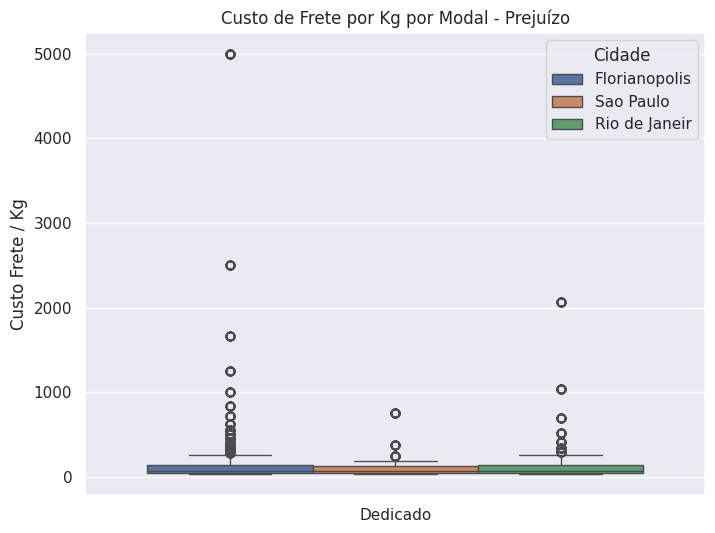

In [118]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df[df['Status_Margem'] == 'Prejuízo'], x='Modal', y='custo_frete_por_kg', hue='Cidade')
plt.title("Custo de Frete por Kg por Modal - Prejuízo")
plt.ylabel("Custo Frete / Kg")
plt.xlabel(None)
plt.savefig('../imagens/custo_frete_por_kg_modal_prej.png', dpi=300)

plt.show()

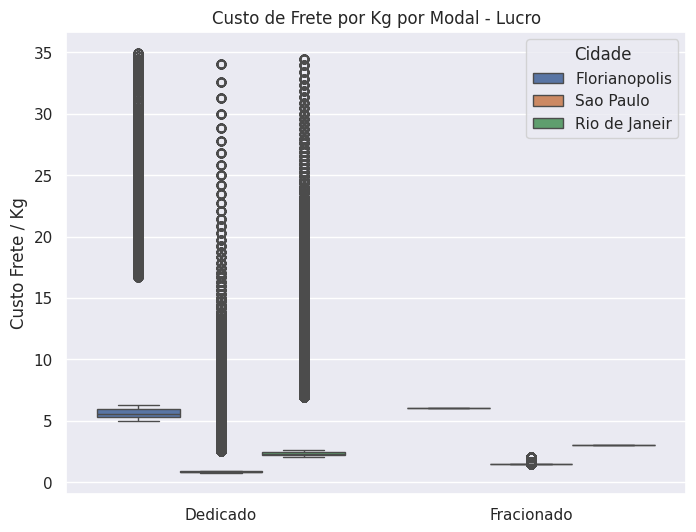

In [119]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df[df['Status_Margem'] == 'Lucro'], x='Modal', y='custo_frete_por_kg', hue='Cidade')
plt.title("Custo de Frete por Kg por Modal - Lucro")
plt.ylabel("Custo Frete / Kg")
plt.xlabel(None)
plt.savefig('../imagens/custo_frete_por_kg_modal_lucro.png', dpi=300)

plt.show()

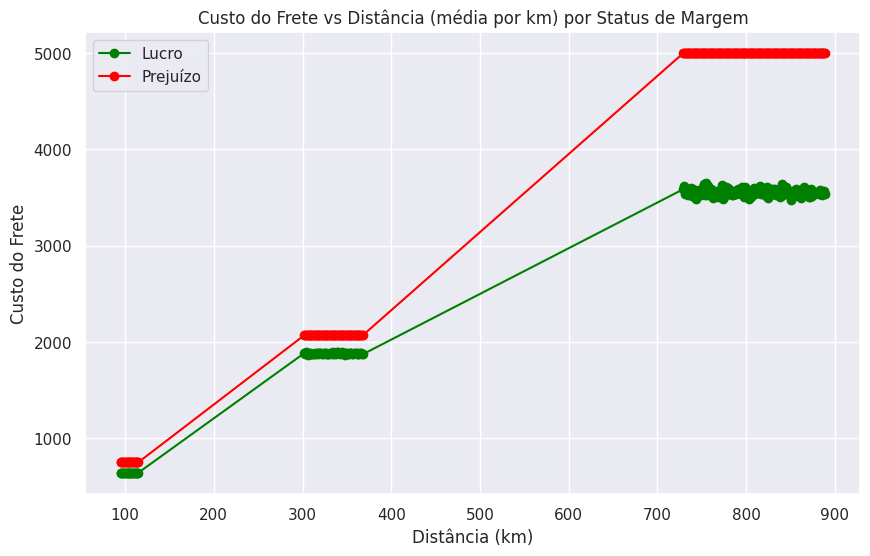

In [102]:
import pandas as pd

# Agrupa por distância e calcula média do Custo_Frete
df_lucro_avg = df[df['Status_Margem'] == 'Lucro'].groupby('Distancia')['Custo_Frete'].mean().reset_index()
df_prejuizo_avg = df[df['Status_Margem'] == 'Prejuízo'].groupby('Distancia')['Custo_Frete'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(df_lucro_avg['Distancia'], df_lucro_avg['Custo_Frete'], marker='o', linestyle='-', color='green', label='Lucro')
plt.plot(df_prejuizo_avg['Distancia'], df_prejuizo_avg['Custo_Frete'], marker='o', linestyle='-', color='red', label='Prejuízo')
plt.xlabel("Distância (km)")
plt.ylabel("Custo do Frete")
plt.title("Custo do Frete vs Distância (média por km) por Status de Margem")
plt.grid(True)
plt.legend()
plt.show()


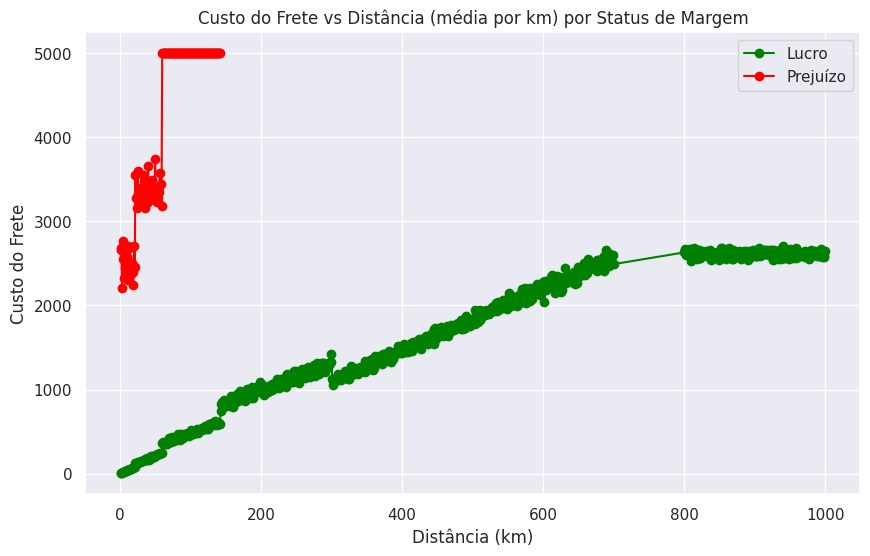

In [103]:
# Agrupa por distância e calcula média do Custo_Frete
df_lucro_avg_3 = df[df['Status_Margem'] == 'Lucro'].groupby('Peso_Kg')['Custo_Frete'].mean().reset_index()
df_prejuizo_avg_3 = df[df['Status_Margem'] == 'Prejuízo'].groupby('Peso_Kg')['Custo_Frete'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(df_lucro_avg_3['Peso_Kg'], df_lucro_avg_3['Custo_Frete'], marker='o', linestyle='-', color='green', label='Lucro')
plt.plot(df_prejuizo_avg_3['Peso_Kg'], df_prejuizo_avg_3['Custo_Frete'], marker='o', linestyle='-', color='red', label='Prejuízo')
plt.xlabel("Distância (km)")
plt.ylabel("Custo do Frete")
plt.title("Custo do Frete vs Distância (média por km) por Status de Margem")
plt.grid(True)
plt.legend()
plt.show()


## 3: Modelagem

Nosso objetivo nesta etapa é propor um modelo que possa sugerir qual deve ser o valor de um pedido para gerar lucro, considerando a distância, o peso, o custo do pedido e o custo do frete.


Inicialmente calculamos a Margem Bruta de um pedido, iremos fazer algo parecido nesta etapa. Nosso objetivo é construir uma equação para o lucro que considere o custo do frete como função da distância e do peso.

As variáveis são:

- $P$ --> Preço do Pedido;
- $C$ --> Custo do Pedido (sem frete)
- $F$ --> Custo do Frete
- $D$ --> Distância percorrida em Km
- $W$ --> Peso da carga em Kg

O lucro simples é:

$$L = P - C - F$$

Mas como comentamos, a custo do frete (F), pode ser escrito como função da Distância (D) e do Peso (W), desta forma iremos conseguir modelar a nossa realidade. Vamos supor que o frete seja proporcional à distância e ao peso:

$$ F(D, W) = a \cdot D + b\cdot W + c\cdot D\cdot W$$

Sendo que os parâmetros $a$, $b$ e $c$ são justamente os indicares que criamos no início, são eles:

- $a$: Custo do Frete por Distância;
- $b$: Custo do Frete por Kg;
- $c$: Custo do Frete por KmKg;

Desta forma teremos:

$$L(D,W) = P - C - (a \cdot D + b\cdot W + c\cdot D\cdot W)$$

Para obtermos os valores de $a$, $b$ e $c$ vamos estimar seus valores com base nos dados fornecidos. E aqui vamos entrar com um pouco de ciência de dados por meio da biblioteca Scikit Learning.

Iniciamos removendo os outliers

In [126]:
df['kmkg'] = df['Distancia'] * df['Peso_Kg']

In [127]:
def remove_outliers_iqr(df, col, k=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    mask = (df[col] >= Q1 - k*IQR) & (df[col] <= Q3 + k*IQR)
    return df[mask]

df_filtrado = remove_outliers_iqr(df, 'Custo_Frete')
df_filtrado = remove_outliers_iqr(df_filtrado, 'Distancia')
df_filtrado = remove_outliers_iqr(df_filtrado, 'Peso_Kg')
df_filtrado = remove_outliers_iqr(df_filtrado, 'kmkg')

In [129]:
import numpy as np
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Dados de entrada
X = df_filtrado[['Distancia', 'Peso_Kg', 'kmkg']].values  # D, W, D*W
y = df_filtrado['Custo_Frete'].values

# Huber
huber = HuberRegressor().fit(X, y)
f0_huber = huber.intercept_
a_huber, b_huber, c_huber = huber.coef_

# RANSAC com estimador LinearRegression
ransac = RANSACRegressor(estimator=LinearRegression(), min_samples=0.5).fit(X, y)
f0_ransac = ransac.estimator_.intercept_
a_ransac, b_ransac, c_ransac = ransac.estimator_.coef_

# Avaliação
y_pred_huber = huber.predict(X)
y_pred_ransac = ransac.predict(X)

print("Huber R2:", r2_score(y, y_pred_huber), "RMSE:", np.sqrt(mean_squared_error(y, y_pred_huber)))
print("Huber params:", f0_huber, a_huber, b_huber, c_huber)

print("RANSAC R2:", r2_score(y, y_pred_ransac), "RMSE:", np.sqrt(mean_squared_error(y, y_pred_ransac)))
print("RANSAC params:", f0_ransac, a_ransac, b_ransac, c_ransac)


Huber R2: 0.9089654574985199 RMSE: 491.4445101868505
Huber params: 0.001108431987997558 0.24258939206133676 0.1478002770226299 0.006467166507081257
RANSAC R2: 0.9138837679630628 RMSE: 477.9845848140532
RANSAC params: 341.620285376767 -0.21630391868046442 -0.2442206887576621 0.007043084356052637


Resultado:

- R²: mede a proporção da variabilidade da variável dependente que o modelo explica.

    - Huber: 90,9% da variação explicada.

    - RANSAC: 91,4% da variação explicada → ligeiramente melhor.

- RMSE (Root Mean Square Error): mede o erro médio em unidades da variável dependente.

    - Huber: 491,44

    - RANSAC: 477,98 → ligeiramente menor erro, também favorecendo RANSAC.

Conclusão sobre desempenho:
Ambos os modelos estão com desempenho muito bom, mas RANSAC está ligeiramente melhor em R² e RMSE. A diferença não é enorme, então ambos são aceitáveis.

In [131]:
# Salvar intercepto e coeficientes
np.save('ransac_intercept.npy', f0_ransac)
np.save('ransac_coef.npy', [a_ransac, b_ransac, c_ransac])

In [133]:
# Carregar parâmetros RANSAC
intercept = np.load('ransac_intercept.npy')
coef = np.load('ransac_coef.npy')  # [a, b, c]
a, b, c = coef

def L(D, W, P, C=0):
    """
    Calcula lucro/margem baseado no modelo RANSAC
    D : Distancia
    W : Peso
    P : Preço do pedido
    C : Custo fixo adicional (opcional)
    """
    custo_estimado = intercept + a*D + b*W + c*D*W
    return P - C - custo_estimado

In [141]:
import numpy as np
import plotly.graph_objects as go
import plotly.offline as pyo

# Carregar parâmetros RANSAC
intercept = np.load('ransac_intercept.npy')
coef = np.load('ransac_coef.npy')
a, b, c = coef

C = 5000  # custo fixo adicional, se houver

# Criar grid de D e W
D = np.linspace(0, 500, 50)   # exemplo: 0 a 500 km
W = np.linspace(0, 200, 50)   # exemplo: 0 a 200 kg
D_grid, W_grid = np.meshgrid(D, W)

# Calcular preço mínimo para lucro >= 30%
custo_estimado = intercept + a*D_grid + b*W_grid + c*D_grid*W_grid
P_min = (custo_estimado + C)/0.7

# Criar superfície interativa
fig = go.Figure(data=[go.Surface(z=P_min, x=D_grid, y=W_grid, colorscale='Viridis')])
fig.update_layout(
    title='Preço mínimo do pedido para lucro ≥ 30%',
    scene=dict(
        xaxis_title='Distancia (km)',
        yaxis_title='Peso (kg)',
        zaxis_title='Preço mínimo'
    ),
    width=800,
    height=600
)

# Abre o gráfico no navegador
pyo.plot(fig, filename='grafico_lucro_3d.html')


'grafico_lucro_3d.html'

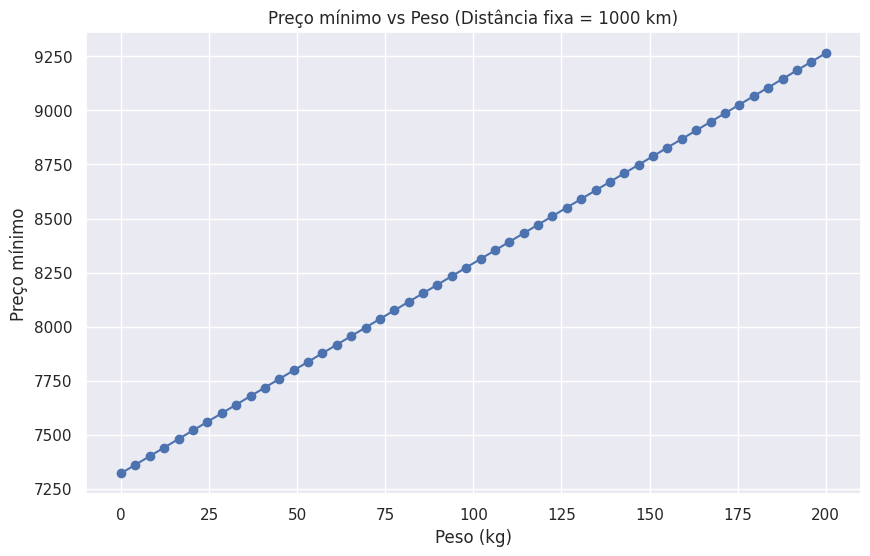

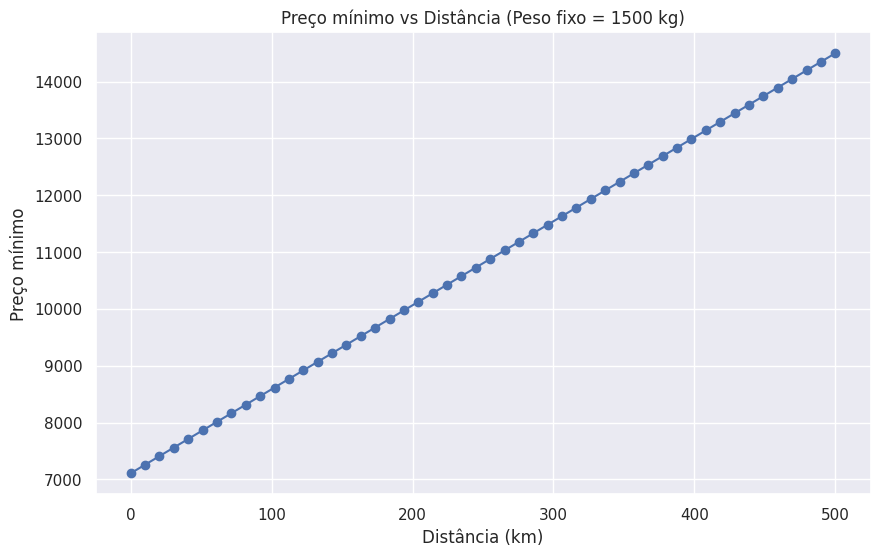

In [144]:
# Carregar parâmetros RANSAC
intercept = np.load('ransac_intercept.npy')
coef = np.load('ransac_coef.npy')
a, b, c = coef

C = 5000  # custo fixo

# Grid de D e W
D = np.linspace(0, 500, 50)   # km
W = np.linspace(0, 200, 50)   # kg

# --------------------------------------------------------
# 1️⃣ Distância fixa
D_fixa = 1000
P_min_D_fixa = (intercept + a*D_fixa + b*W + c*D_fixa*W + C)/0.7

plt.figure(figsize=(10,6))
plt.plot(W, P_min_D_fixa, marker='o')
plt.title(f'Preço mínimo vs Peso (Distância fixa = {D_fixa} km)')
plt.xlabel('Peso (kg)')
plt.ylabel('Preço mínimo')
plt.grid(True)
plt.savefig('../imagens/lucro_peso.png', dpi=300)

plt.show()

# --------------------------------------------------------
# 2️⃣ Peso fixo
W_fixo = 1500
P_min_W_fixo = (intercept + a*D + b*W_fixo + c*D*W_fixo + C)/0.7

plt.figure(figsize=(10,6))
plt.plot(D, P_min_W_fixo, marker='o')
plt.title(f'Preço mínimo vs Distância (Peso fixo = {W_fixo} kg)')
plt.xlabel('Distância (km)')
plt.ylabel('Preço mínimo')
plt.grid(True)
plt.savefig('../imagens/lucro_km.png', dpi=300)

plt.show()

Podemos pegar os pontos que mais repetem a distância e o peso para comparar com o nosso modelo.

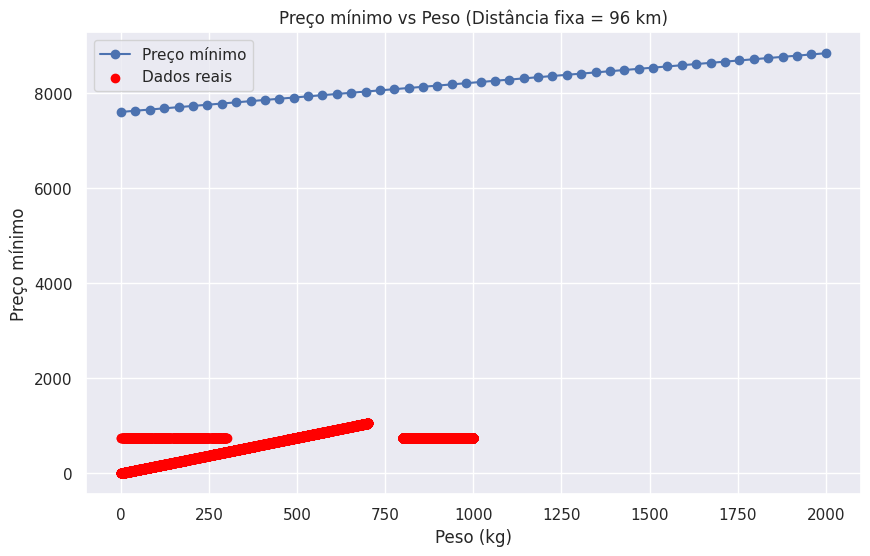

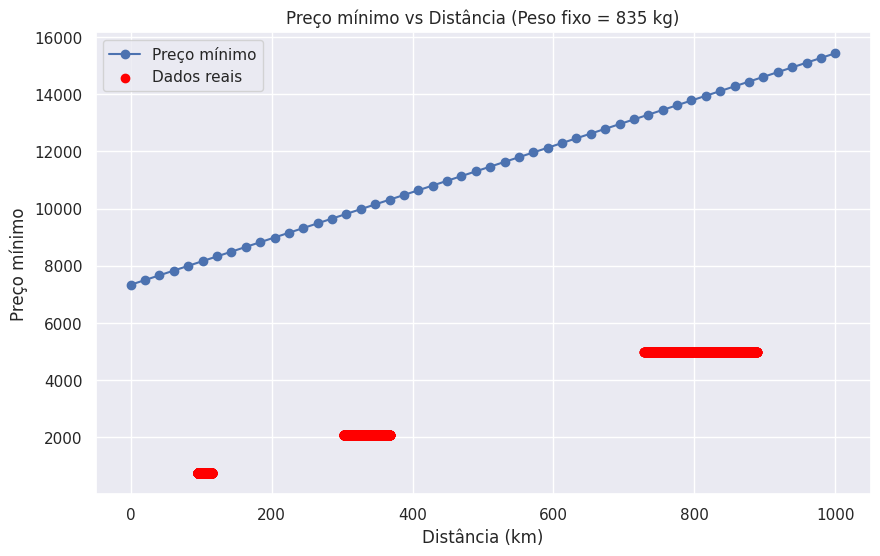

In [154]:
import matplotlib.pyplot as plt
import numpy as np

# Carregar parâmetros RANSAC
intercept = np.load('ransac_intercept.npy')
coef = np.load('ransac_coef.npy')
a, b, c = coef

C = 5000  # custo fixo

# Grid de W e D
W = np.linspace(0, 2000, 50)   # kg
D = np.linspace(0, 1000, 50)   # km

# --------------------------------------------------------
# 1️⃣ Distância fixa D = 96
D_fixa = 96
P_min_D_fixa = (intercept + a*D_fixa + b*W + c*D_fixa*W + C)/0.7

# Filtrar dados reais com Distancia = 96
df_D96 = df_filtrado[df_filtrado['Distancia'] == D_fixa]

plt.figure(figsize=(10,6))
plt.plot(W, P_min_D_fixa, marker='o', label='Preço mínimo')

# Pontos reais filtrados
plt.scatter(df_D96['Peso_Kg'], df_D96['Custo_Frete'], color='red', label='Dados reais')

plt.title(f'Preço mínimo vs Peso (Distância fixa = {D_fixa} km)')
plt.xlabel('Peso (kg)')
plt.ylabel('Preço mínimo')
plt.grid(True)
plt.legend()
plt.savefig('../imagens/lucro_peso_com_dados_D96.png', dpi=300)
plt.show()

# --------------------------------------------------------
# 2️⃣ Peso fixo W = 835
W_fixo = 835
P_min_W_fixo = (intercept + a*D + b*W_fixo + c*D*W_fixo + C)/0.7

# Filtrar dados reais com Peso_Kg = 835
df_W835 = df_filtrado[df_filtrado['Peso_Kg'] == W_fixo]

plt.figure(figsize=(10,6))
plt.plot(D, P_min_W_fixo, marker='o', label='Preço mínimo')

# Pontos reais filtrados
plt.scatter(df_W835['Distancia'], df_W835['Custo_Frete'], color='red', label='Dados reais')

plt.title(f'Preço mínimo vs Distância (Peso fixo = {W_fixo} kg)')
plt.xlabel('Distância (km)')
plt.ylabel('Preço mínimo')
plt.grid(True)
plt.legend()
plt.savefig('../imagens/lucro_km_com_dados_W835.png', dpi=300)
plt.show()


O projeto de análise de eficiência de fretes teve como objetivo principal identificar pedidos ineficientes na distribuição de livros didáticos, com foco em otimizar os custos e melhorar a margem de lucro. Através da análise exploratória e da modelagem, foram alcançados os seguintes resultados:

1. Identificação de Pedidos Ineficientes:

    - Analisando os dados, aproximadamente 0,75% dos pedidos apresentaram margem bruta negativa, gerando um prejuízo total de R$ 14,3 milhões.

    - Todos os pedidos com prejuízo utilizaram o modal dedicado, indicando que esse modal pode não ser a opção mais econômica para certos cenários.

2. Métricas de Desempenho:

    - Foram calculadas métricas como margem bruta, custo de frete por peso, custo de frete por distância e markup, que permitiram uma avaliação detalhada da eficiência dos fretes.

    - A análise revelou que o custo do frete por km e por kg é significativamente maior para pedidos com prejuízo, especialmente no modal dedicado.

3. Modelagem Preditiva:

    - Um modelo de regressão (RANSAC) foi desenvolvido para estimar o custo do frete com base na distância e no peso, explicando 91,4% da variabilidade dos dados.

    - O modelo permitiu calcular o preço mínimo necessário para garantir uma margem de lucro de 30%, considerando diferentes combinações de distância e peso.

4. Visualização de Dados:

    - Gráficos interativos e estáticos foram utilizados para ilustrar a relação entre distância, peso, custo do frete e margem de lucro, facilitando a interpretação dos resultados.

Pontos Futuros para Melhoria
Para aprimorar o projeto e expandir sua aplicabilidade, as seguintes ações podem ser consideradas:

1. Análise por Modal de Transporte:

    - Diferenciar os modelos de custo para os modais dedicado e fracionado, identificando qual é mais vantajoso em cada cenário.

    - Avaliar a capacidade ociosa no modal dedicado e propor consolidação de cargas para reduzir custos.

2. Testes de Hipóteses:

    - Realizar testes estatísticos para verificar se há diferenças significativas nos custos de frete entre cidades, modais ou períodos do ano.

    - Investigar se pedidos com prejuízo estão associados a rotas específicas ou clientes com características particulares.

3. Análise de Sazonalidade:

    - Identificar se os pedidos ineficientes estão concentrados em determinados períodos do ano, como datas de pico de demanda, e propor ajustes nos preços ou na logística.

4. Recomendações Estratégicas:

    - Sugerir políticas de preços dinâmicos que considerem distância, peso e modal para maximizar a margem de lucro.

    - Propor parcerias com transportadoras para negociar melhores tarifas com base no volume de pedidos.

Considerações Finais

O projeto demonstrou que a análise de dados pode ser uma ferramenta poderosa para identificar ineficiências e oportunidades de otimização na logística de distribuição. Com as melhorias sugeridas, será possível não apenas reduzir custos, mas também aumentar a competitividade e a satisfação dos clientes. A implementação de um ciclo contínuo de análise e ajuste garantirá que os resultados sejam sustentáveis no longo prazo.